<a href="https://colab.research.google.com/github/juankuntz/LPAE/blob/master/notebooks/MNIST_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we fit an LPAE to the MNIST dataset. For more info on the model and training procedure, see [here](https://lpae.readthedocs.io/en/latest/).

**Note**: The notebook runs significantly faster on a GPU (on Colab, select from the top bar Runtime -> 
Change runtime type -> accelerator -> GPU).

# Setup

Are you running this notebook on Colab or locally? In the former case, set the following COLAB parameter to true, in the latter, set it to false and specify the path to the repository.

In [1]:
COLAB = False

In [2]:
import os

# Specify path (the following command does the trick if
# you launched jupyter-lab from the notebook's directory).
REPOSITORY_PATH = os.path.dirname(os.getcwd())

If running on Colab, we need to download the respository:

In [3]:
%%capture

if COLAB:
    # Mount gdrive:
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=False) 
    
    # Load the repository:
    import sys
    !rm -rf LPAE
    REPOSITORY_PATH = '/content/lpae'
    !git clone https://github.com/juankuntz/LPAE.git $REPOSITORY_PATH

In either case, we need the following modules:

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras.layers import Conv2DTranspose, Dense, Reshape, Input, Average
from tensorflow.keras import Sequential, Model
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

2023-04-20 13:01:55.444569: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 13:01:55.493679: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 13:01:56.380987: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Lastly, we add the repository to the system's path and load the LPAE object:

In [5]:
import sys

# Add repository to system path:
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

# Import the LPAE object:
from src.autoencoders import LPAE

# Model definition and training

**Training data**: Let's fetch $10,000$ MNIST images to train our model with (we also fetch another $1000$ for testing):

In [6]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x, y = tf.constant(x[:10000].astype('float32')[..., np.newaxis]), y[:10000]
x_test, y_test = tf.constant(x_test[:1000].astype('float32')[..., np.newaxis]), y_test[:1000]
data = tf.data.Dataset.from_tensor_slices(x)

Let's check that these are what we expect:

In [7]:
#@title Definition of plot_images()
def plot_images(image_batch: tf.Tensor, names: list[str] = None) -> None:
    """
    Plots batch of images.

    Parameters
    ----------
    image_batch: tf.Tensor with dimensions (batch_size, 28, 28, 1)
        Batch of images.
    names: list[str] or None
        Corresponding list of names.
    """
    images = [image_batch[i, ...].numpy()[..., 0] 
            for i in range(image_batch.shape[0])]
    if not names:
        names = ['' for _ in images]
    grid_size = math.ceil(len(images) ** (1/2))
    for i, (image, name) in enumerate(zip(images, names)):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        ax.set_title(name)
        plt.imshow(255 - image.astype("uint8"), cmap='Greys')
        plt.axis("off")
    plt.gcf().tight_layout()    
    plt.show()

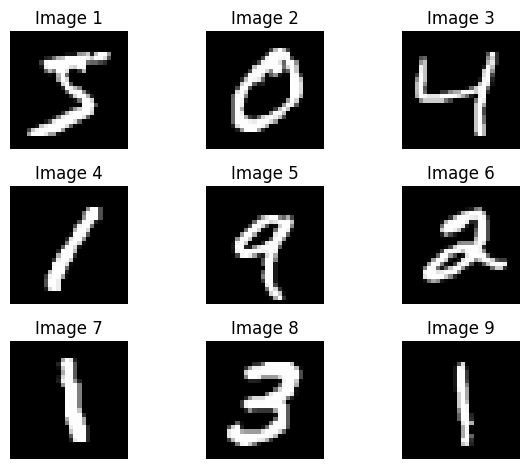

In [8]:
# Plot first nine images:
plot_images(x[:9], [f'Image {i+1}' for i in range(9)])

**Model definition**: To define the model, we need to choose the latent space's dimension and then define a decoder mapping from this space to the data space ($\mathbb{R}^{28\times28}$ as we are dealing with $28\times 28$ greyscale images). Let's try $2$ for the dimension and the simple convolutional decoder used in [this keras VAE tutorial](https://keras.io/examples/generative/vae/):

                    Decoder with 159169 parameters


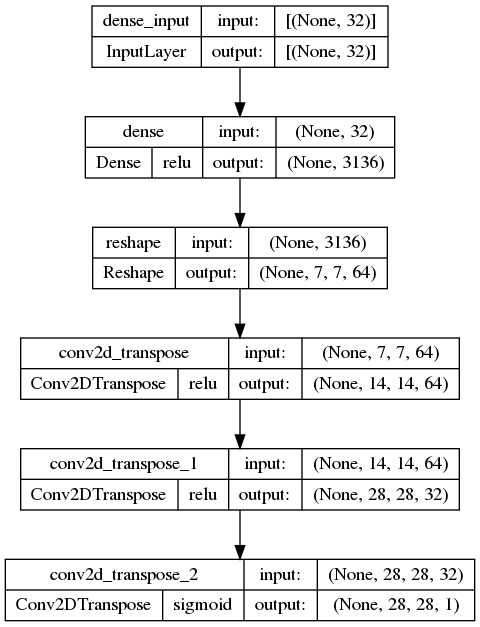

In [9]:
latent_dimensions = 32  
decoder = Sequential([Dense(7 * 7 * 64, activation="relu",
                             input_shape=(latent_dimensions,)),
                       Reshape((7, 7, 64)),
                       Conv2DTranspose(64, 3, activation="relu", strides=2,
                                       padding="same"),
                       Conv2DTranspose(32, 3, activation="relu", strides=2,
                                       padding="same"),
                       Conv2DTranspose(1, 3, activation="sigmoid",
                                       padding="same")
                       ], name='decoder')

n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in decoder.trainable_variables])
print(f'                    Decoder with {n_parameters} parameters')
print('===================================================================')
tf.keras.utils.plot_model(decoder, show_shapes=True, show_layer_activations=True)

We can now define the entire model:

In [10]:
model = LPAE(latent_dimensions=latent_dimensions, decoder=decoder, observation_noise_std=1e-2)

**Training**: Training entails optimizing over the parameters $\theta$ of the decoder. To do so, we use:
- $10$ particles,
- a learning rate of $0.0005$ for the latent variable updates,
- and an RMSProp optimizer for the decoders parameter updates.

The decoder's final layer uses a sigmoid activation function, and, so, maps to $[0,1]^{28\times28}$. Hence, we ought to normalize the images so that the lie in $[0,1]^{28\times28}$. We can get the model to handle this internally for us by feeding it to appropiate  `preprocessor` and `postprocessor` layers (the former normalizes, the latter unnormalizes, and both must be [keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)). We have all we need to configure the training:

In [11]:
n_particles = 10
model.compile(lv_learning_rate=5e-4, n_particles=n_particles,
              optimizer=tf.keras.optimizers.RMSprop(),
              preprocessor=tf.keras.layers.Rescaling(scale=1./255),
              postprocessor=tf.keras.layers.Rescaling(scale=255.))

We can now train the model by calling its fit method, passing in the data, the number of epochs we want it to train for, and the batch size we'd like it to use:

In [12]:
model = LPAE.from_save('../test_save/')
# model.fit(data=data, epochs=30, batch_size=256)  

/home/jk/anaconda3/envs/paremtf/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Inference

We've fitted the model to the dataset, so what can we do with it? Before answering that question, let's first get a bit more of a feel for how the model works. 

## Visualizing the posterior approximation

As discussed in the [docs](https://lpae.readthedocs.io/en/latest/) (in what follows, we use the notation introduced there), the model assumes that each image $y^m$ in our training set was generated by mapping a vector of latent variables $x^m$ to the image space via the decoder $f_{\theta_K}:\mathbb{R}^{32}\to\mathbb{R}^{28\times28}$ (and adding a bit of Gaussian noise). It doesn't pressume to know what $x^m$ is and instead offers $N:=10$ guesses that it deems equally as likely: $X^{1,m}_K,\dots, X^{N,m}_K$ which we refer to as 'particles'. We can visualize by plotting them their coordinates one at a time:

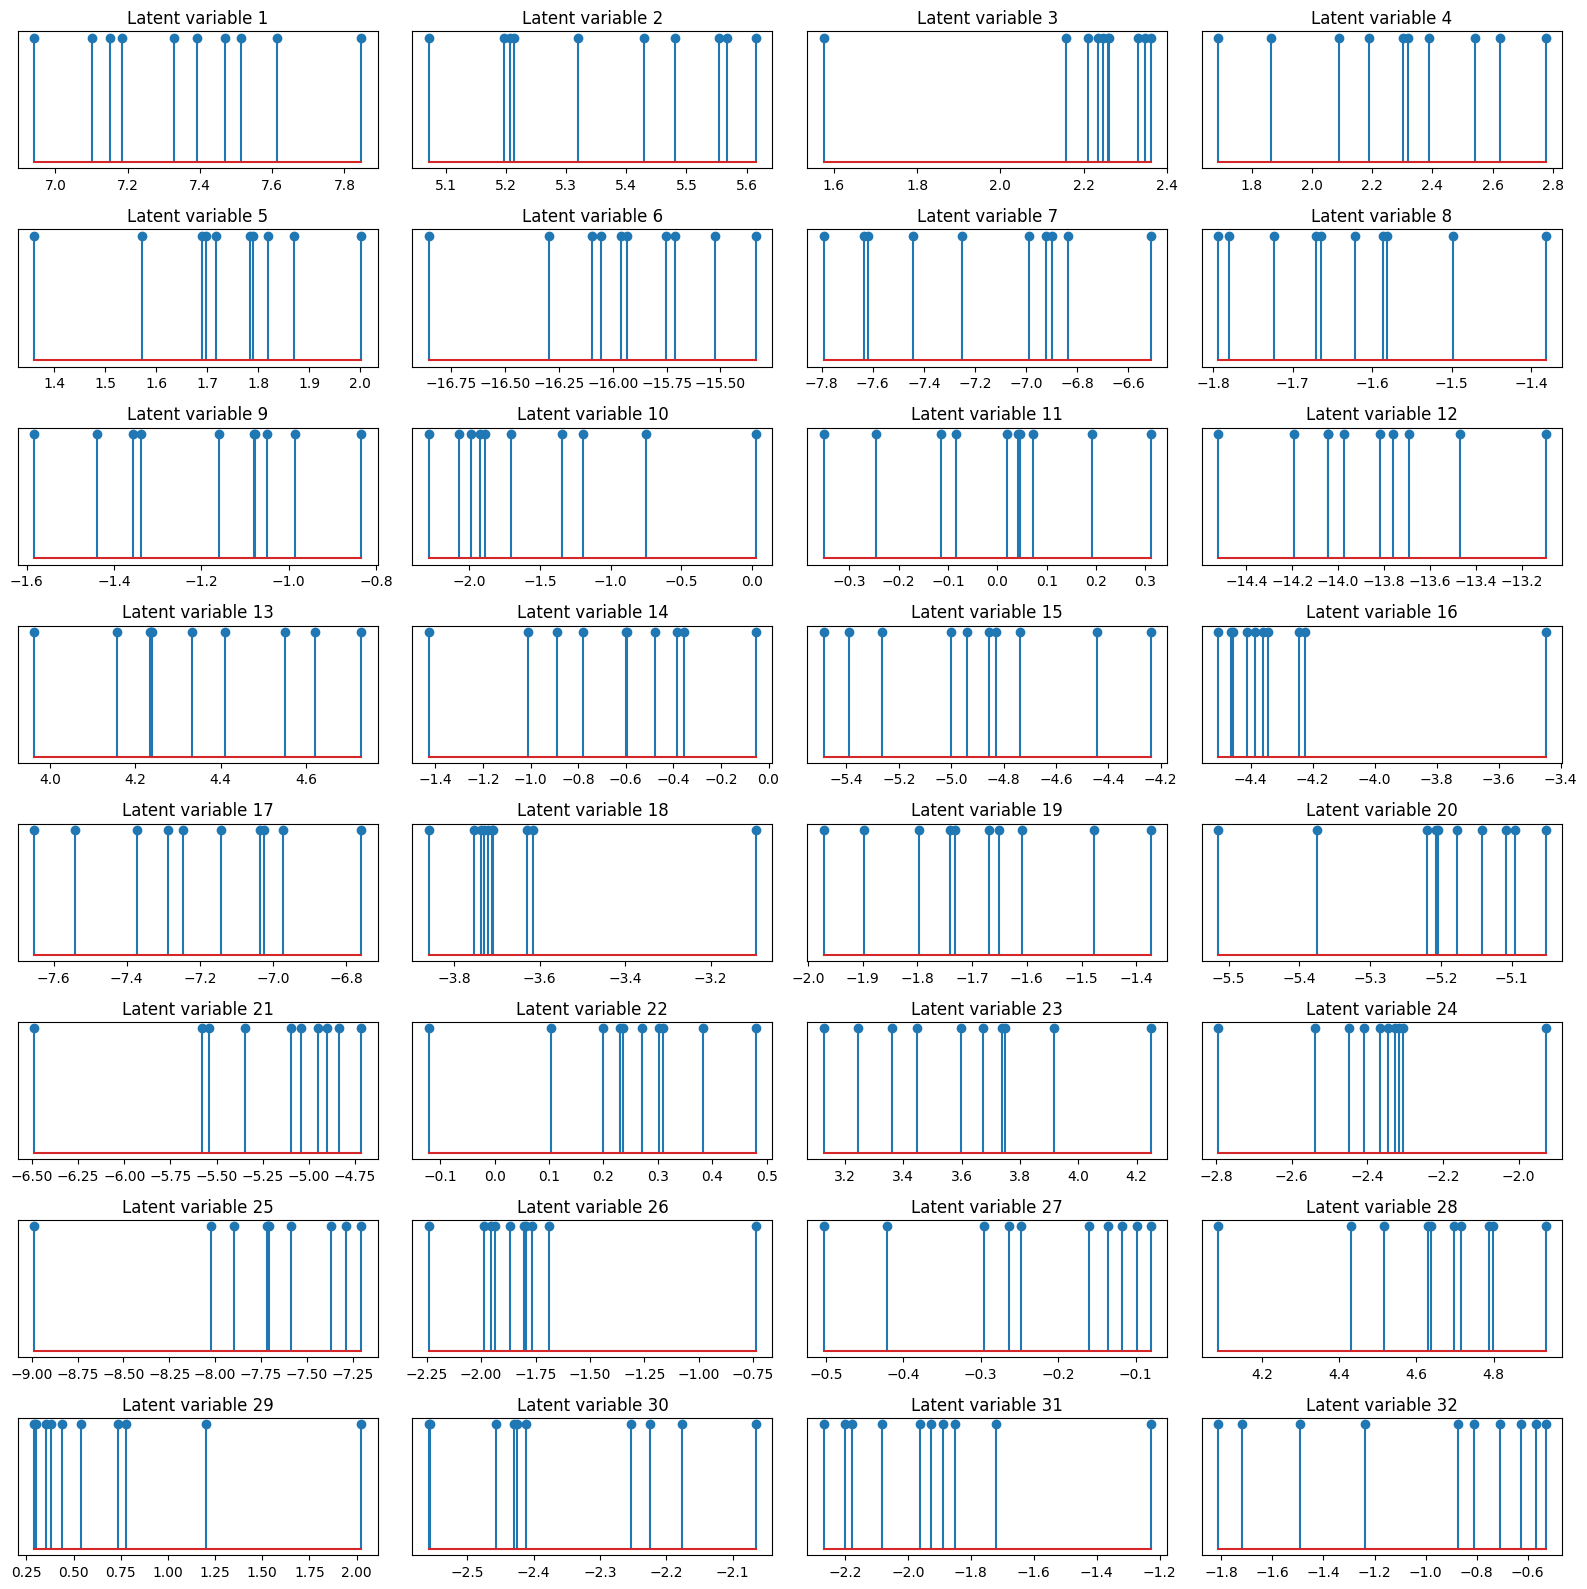

In [13]:
i = 0

# Get particles for the ith image:
particles = model.get_particles(index_batch=[i])[0, :, :]

# Plot them:
plt.figure(figsize=(16, 16))
grid_size = math.ceil(latent_dimensions ** (1/2))
for j in range(latent_dimensions):
    ax = plt.subplot(8, 4, j + 1)
    ax.set_title(f'Latent variable {j + 1}')
    ax.get_yaxis().set_visible(False)
    plt.stem(particles[:, j].numpy(), np.ones(10))
plt.gcf().tight_layout()    
plt.show()

Equivalently, we can think of the model returning, for each image $y^m$, a distribution over the possible values of $x^m$ defined by the empirical distribution of these particles: $N^{-1}\sum_{n=1}^N\delta_{X_K^{n,m}}$. We can visualize this distribution by examining it's marginals (and with the help of a KDE):

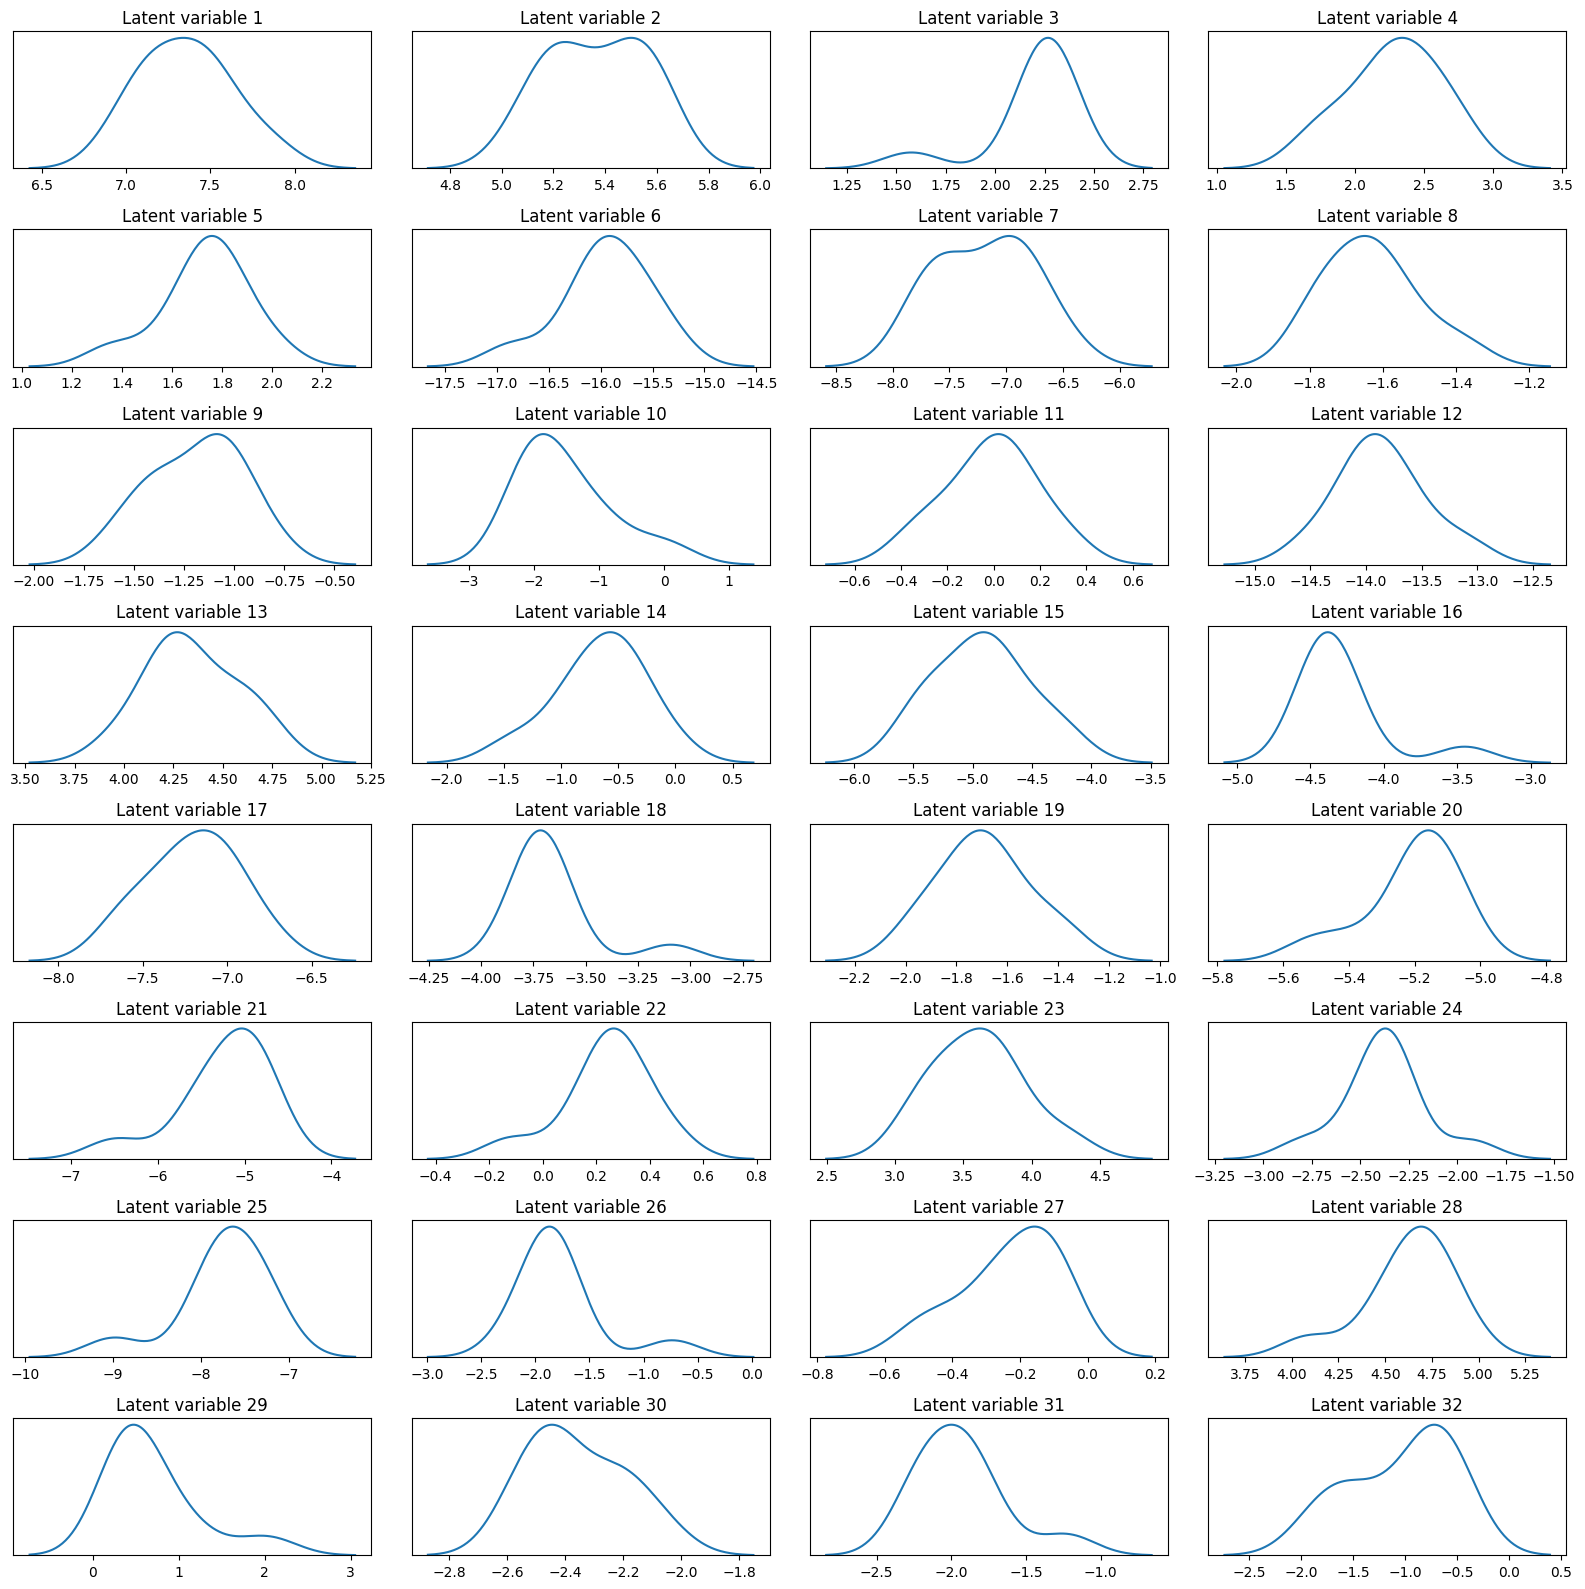

In [14]:
# Plot them:
plt.figure(figsize=(16, 16))
grid_size = math.ceil(latent_dimensions ** (1/2))
for j in range(latent_dimensions):
    ax = plt.subplot(8, 4, j + 1)
    ax.set_title(f'Latent variable {j + 1}')
    ax.get_yaxis().set_visible(False)
    sns.kdeplot(particles[:, j].numpy(), ax=ax)
plt.gcf().tight_layout()    
plt.show()

We refer to this distribution as an 'approximate posterior' because it approximates 

$$p_{\theta_K}(x^m|y^m)=\frac{p_{\theta_K}(x^m,y^m)}{p_{\theta_K}(y^m)}.$$

While the distribution doesn't look particularly peaked, it's pushforward through the decoder is actually very peaked around the training image $y^m$. In other words, mapping any of the particles through the decoder we get an image almost indistinguishable from $y^m$:

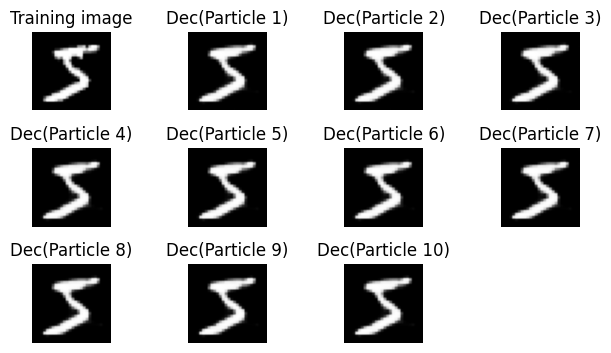

In [15]:
decoded_particles = model.decode_particles(index_batch=[i])
names = ['Training image'] + [f'Dec(Particle {j+1})' 
                              for j in range(n_particles)]
plot_images(tf.concat([x[i][tf.newaxis, ...], decoded_particles], axis=0), names)

## Representations 

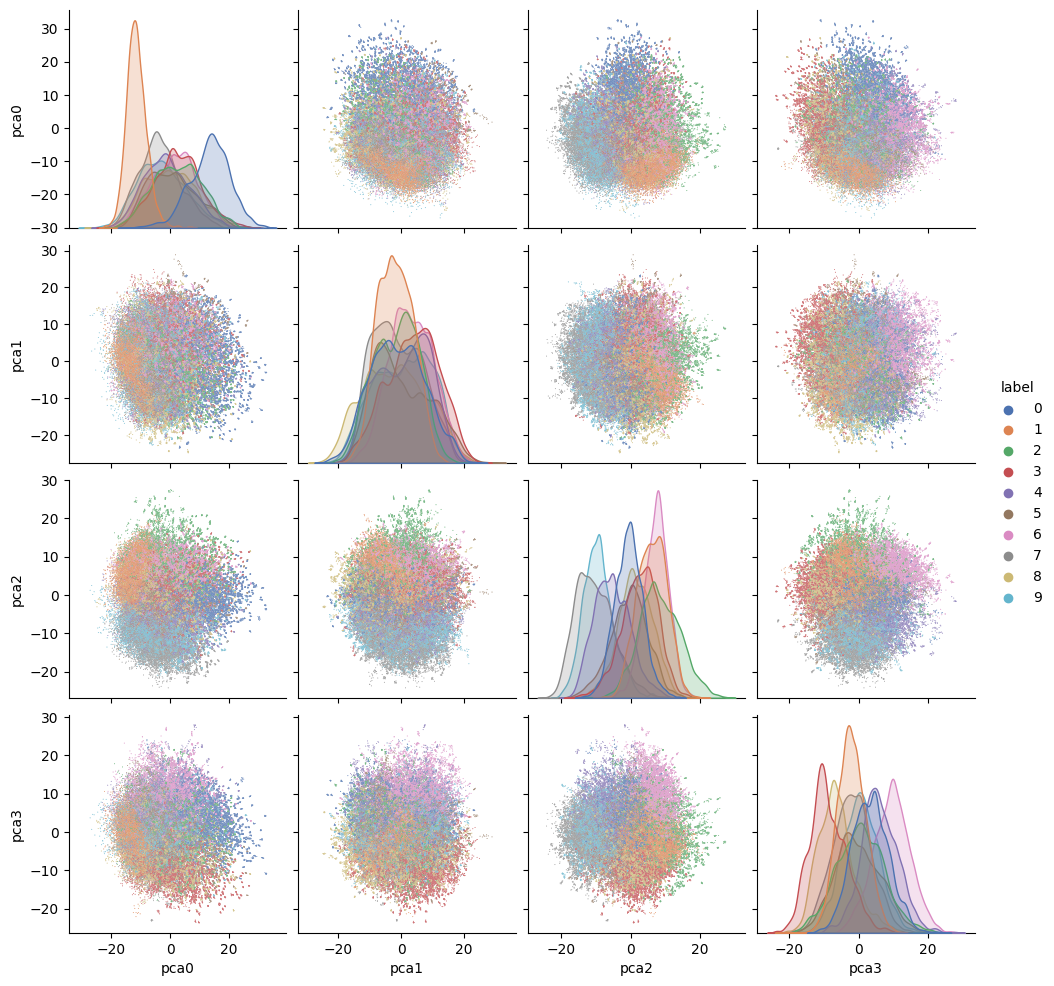

In [16]:
particles = pd.DataFrame(model.flatten_particles(model.get_particles()).numpy(),
                         columns=[f'Latent variable {i}' for i in range(latent_dimensions)])
particles_pca = PCA(n_components=4).set_output(transform='pandas').fit_transform(particles)
particles_pca['label'] = np.repeat(y, n_particles)
sns.pairplot(particles_pca, hue='label', palette='deep', plot_kws={'s': 0.5})

In [17]:
# n = 100000  # Number of particles to include in plot.
# lvs = [0, 1, 2, 3]  # List of latent variables to include in plot.
# # particles['label'] = np.repeat(y, n_particles)

# # from sklearn import set_config
# # set_config(transform_output = "pandas")

# from sklearn.decomposition import PCA
# # plot_particles = particles.head(n)[[f'Latent variable {i}' for i in lvs] + ['label']]
# plot_particles = PCA(n_components=4).set_output(transform='pandas').fit_transform(particles.head(n))
# plot_particles['label'] = np.repeat(y[:int(n/n_particles)], n_particles)
# sns.pairplot(plot_particles, hue='label', palette='deep', plot_kws={'s': 0.5})

Error in callback <function flush_figures at 0x7f85aa38e830> (for post_execute):


KeyboardInterrupt: 

## What about images not in our training set?

## Recovering images corrupted with noise

In [18]:
#@title Definition of corrupt()

def corrupt(images: tf.Tensor, noise_intensity: float = 0.3):
    images += noise_intensity * 255 * tf.random.normal(shape=images.shape)
    images *= 1 + noise_intensity * (tf.random.uniform(shape=images.shape) - 0.5)
    return tf.minimum(tf.maximum(images, 0), 255)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


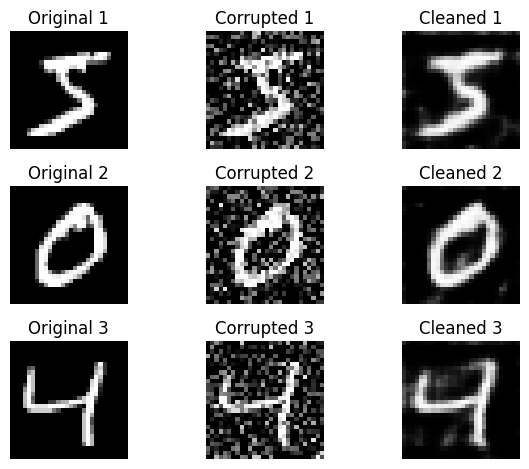

In [19]:
n_images = 3
images = x[:n_images, ...]
corrupted = corrupt(images)
reconstructed = model(corrupted, n_steps=1000)
names = sum([[f'Original {i + 1}', f'Corrupted {i + 1}', f'Cleaned {i + 1}']
             for i in range(n_images)], [])
interweaved = tf.reshape(tf.stack([images, corrupted, reconstructed], axis=1),
                         (3 * n_images,) + images.shape[1:])
plot_images(interweaved, names)

## Generating fakes

In [20]:
fakes = model.generate_fakes(n_fakes=64, n_components=30)
plot_images(fakes)

KeyboardInterrupt: 

#Saving and loading the model

In [ ]:
# Save:
# model.save('gdrive/MyDrive/model_ckpt/')
# Load:
# model = autoencoders.LPAE.from_save('gdrive/MyDrive/model_ckpt/')

## Classifying

In [27]:
# On representations:
clf = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='softmax')
])

clf.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
clf.fit(model.flatten_particles(model.get_particles()).numpy(), np.repeat(y, n_particles), epochs=10, validation_split=0.2)

# # On raw images:
# clf = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28)),
#     tf.keras.layers.Rescaling(scale=1./255),
#     tf.keras.layers.Dense(10)
# ])
# clf.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# clf.fit(x, y, epochs=10, validation_split=0.2)

Epoch 1/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2577 - accuracy: 0.7621 - val_loss: 0.5076 - val_accuracy: 0.8625
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3802 - accuracy: 0.8865 - val_loss: 0.4990 - val_accuracy: 0.8576
Epoch 3/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3773 - accuracy: 0.8865 - val_loss: 0.4895 - val_accuracy: 0.8590
Epoch 4/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3753 - accuracy: 0.8867 - val_loss: 0.4956 - val_accuracy: 0.8588
Epoch 5/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3739 - accuracy: 0.8878 - val_loss: 0.4966 - val_accuracy: 0.8583
Epoch 6/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3733 - accuracy: 0.8881 - val_loss: 0.4999 - val_accuracy: 0.8594
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3733 - accuracy: 0.8868 - val_loss: 0.4976 - val_accuracy:

KeyboardInterrupt: 

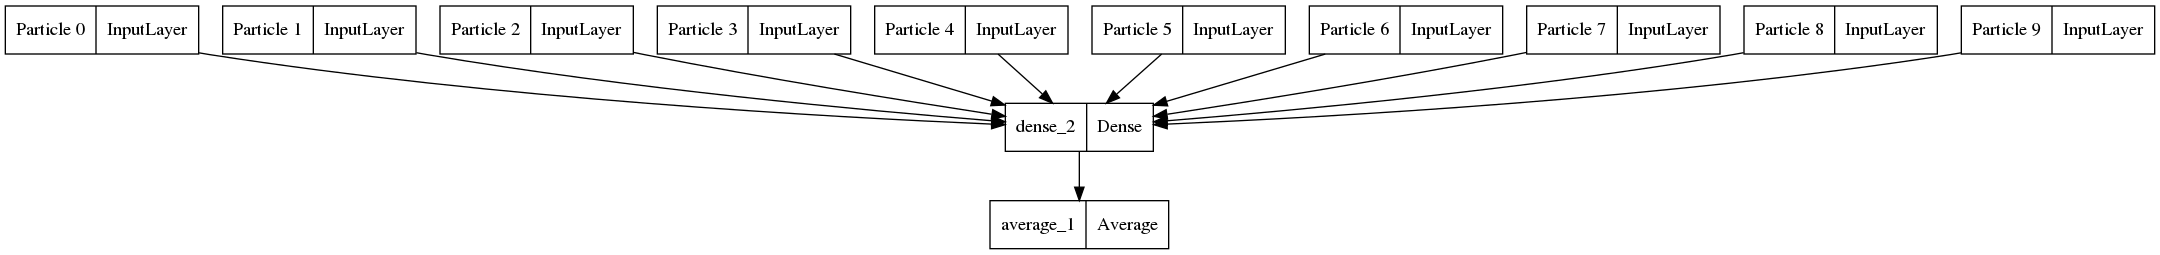

In [22]:
inputs = [Input(shape=(latent_dimensions,), name=f'Particle {i}') for i in range(n_particles)]
fully_connected = Dense(10, input_shape=(latent_dimensions,), activation='softmax')
h = [fully_connected(particle) for particle in inputs]
output = Average()(h)
clf = Model(inputs=inputs, outputs=output)
tf.keras.utils.plot_model(clf)

In [25]:
particles = model.get_particles()
clf.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
clf.fit([particles[:, i, :] for i in range(n_particles)], y, epochs=30, validation_split=0.2)

Epoch 1/30
250/250 [==============================] - 1s 3ms/step - loss: 0.3831 - accuracy: 0.8857 - val_loss: 0.5130 - val_accuracy: 0.8610
Epoch 2/30
250/250 [==============================] - 0s 2ms/step - loss: 0.3774 - accuracy: 0.8880 - val_loss: 0.5044 - val_accuracy: 0.8640
Epoch 3/30
250/250 [==============================] - 0s 2ms/step - loss: 0.3738 - accuracy: 0.8891 - val_loss: 0.5043 - val_accuracy: 0.8580
Epoch 4/30
250/250 [==============================] - 0s 2ms/step - loss: 0.3720 - accuracy: 0.8880 - val_loss: 0.4996 - val_accuracy: 0.8610
Epoch 5/30
250/250 [==============================] - 0s 2ms/step - loss: 0.3714 - accuracy: 0.8901 - val_loss: 0.4951 - val_accuracy: 0.8665
Epoch 6/30
250/250 [==============================] - 0s 2ms/step - loss: 0.3704 - accuracy: 0.8905 - val_loss: 0.4925 - val_accuracy: 0.8565
Epoch 7/30
250/250 [==============================] - 0s 2ms/step - loss: 0.3699 - accuracy: 0.8898 - val_loss: 0.4910 - val_accuracy: 0.8600
Epoch 